# Exercise 11) Eligibility Traces

In this exercise we will explore whether we can enhance the learning behavior within the MountainCar environment when using eligibility traces. The basic idea behind eligibility traces is that - much like in n-step learning - past actions contributed to the current situation. Contrary to n-step learning, however, intuition tells us that more recent decisions had a more severe impact on the present situation than decisions that were made a long time ago. Thus, it may be helpful to integrate a forgetting factor $\lambda$ which decreases the assumed influence of actions over time.

Once again we will be looking at the MountainCar with discrete action space.

![](SarsaGridworld.png)

In [1]:
import numpy as np
import gym
import random
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
from mpl_toolkits.mplot3d import Axes3D
from collections import deque
from sklearn.kernel_approximation import RBFSampler
import sklearn.pipeline
import sklearn.preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

## 0) Preprocessing Gradients

For many applications we are not satisfied with directly using the `apply_gradients` function from Tensorflow. We often need to process the gradients before applying them to our ANN. E.g. in the case of Sarsa($\lambda$) we want to compute

\begin{align}
\mathbf{z}_\text{new} = \gamma \lambda \mathbf{z}_\text{old} + \nabla_\mathbf{w}\hat{q}(\mathbf{x}_{k},u_{k},\mathbf{w})
\end{align}

before applying the gradient

\begin{align}
\mathbf{w}_\text{new} = \mathbf{w}_\text{old} + \alpha \delta \mathbf{z}_\text{new}.
\end{align}

Thus, we need to provide for two things. Firstly, we need to calculate the gradient $\nabla_\mathbf{w}\hat{q}(\mathbf{x}_{k},u_{k},\mathbf{w})$. Secondly, we need to process it accordingly.

(Recall that in the last exercise we were applying the gradient
\begin{align}
\mathbf{w}_\text{new} = \mathbf{w}_\text{old} + \alpha \delta \nabla_\mathbf{w}\hat{q}(\mathbf{x}_{k},u_{k},\mathbf{w}),
\end{align}
which we were able to compute easily using a quadratic loss function (mean squared error).) 

Note that we do not use a quadratic loss function this time! This is due to the difference in the handling of gradients in exercise 10 and 11 as presented in [this PDF](TF_Gradients.pdf).

Take a look at the code snippet below and try to understand what's supposed to happen there. The code is only an excerpt, so it is not executable, but this examplary application should give a good orientation on how to tackle task (1).

In [ ]:
### example: how to apply gradients manually ###

# define a mean loss function
mean = tf.keras.backend.mean

# suppose that gradients are given by
with tf.GradientTape() as tape:
    action_values = model(norm_state)
    loss = mean(action_values[0][action])
gradients = tape.gradient(loss, model.trainable_variables)

### the following code replaces the opt.apply_gradients(zip(gradients, model.trainable_variables)) command ###

# get the weights from the model, this is a list of arrays so we cannot perform calculations on it,
# we have to carry out calculations per list element
w = model.get_weights()

# go over each element
for i in range(len(w)):
    w[i] += alpha * delta * gradients[i] 
    # gradients as computed per tape.gradient(...) have the same structure as model.get_weights()
    
# put the freshly updated weights back into the model
model.set_weights(w)

## 1) Sarsa($\lambda$) with Neural Networks

Write a Sarsa($\lambda$) algorithm to modify the learning behavior of an ANN function approximator. Test it for different values of $\lambda$. How sensitive is the process to the choice of $\lambda$?

In [ ]:
def plot_surface(model, input_dim):
    resolution = 100
    pos_vec = np.linspace(-1.2, 0.6, resolution)
    vel_vec = np.linspace(-0.07, 0.07, resolution)

    pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
    state_tensor = np.zeros([resolution, resolution, input_dim])

    for pos_idx, pos in enumerate(tqdm(pos_vec)):
        for vel_idx, vel in enumerate(vel_vec):
            state_tensor[vel_idx, pos_idx] = featurize(np.array([pos, vel]))

    q_mat = model(state_tensor)
    q_maxes = np.reshape(np.max(q_mat, axis=2), (resolution, resolution))
    

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(pos_mat, vel_mat, -q_maxes, cmap="viridis")
    ax.set_xlabel('\n\nposition')
    ax.set_ylabel('\n\nvelocity')
    ax.set_zlabel(r'$-V_\mathrm{greedy}$', labelpad=12)
    ax.view_init(50, -135)
    plt.show()

In [4]:
env = gym.make('MountainCar-v0')
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state):
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    return featurized

In [ ]:
alpha = 0.0001
gamma = 1
_lambda = 0.1
epsilon = 0.15
nb_episodes = 300

env = gym.make('MountainCar-v0')

state = env.reset()
norm_state = featurize(state)
input_dim = len(norm_state[0])


# define ANN topology
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=input_dim))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='linear'))

mean = tf.keras.backend.mean
opt = SGD(learning_rate=alpha)

needed_steps_lambda = []

for j in tqdm(range(nb_episodes)):
    k = 0
    rewards = 0

    # initialize z to zero; 
    # needs to be done in a loop because get_weights and gradients are lists 
    # of arrays that preserve the structure of the ANN
    z = model.get_weights()
    for i in range(len(z)):
        z[i] = z[i] * 0

    state = env.reset()
    norm_state = featurize(state)

    action_values = np.squeeze(model(norm_state).numpy())

    # Choose Initial Action greedy
    if epsilon < np.random.rand(1):
        action = np.argmax(action_values)
    else:
        action = random.choice(range(3))

    while True:
        # env.render()
        k += 1

        ### STEP        
        next_state, reward, done, _ = env.step(action)            
        norm_next_state= featurize(next_state)
        rewards += reward


        action_value = np.squeeze(model(norm_state).numpy())[action]
        if done:
            target = reward
        else:
            # epsilon greedy action selection
            next_action_values = np.squeeze(model(norm_next_state).numpy())
            if epsilon < np.random.rand(1):
                next_action = np.argmax(next_action_values)
            else:
                next_action = random.choice(range(3))

            next_action_value = next_action_values[next_action]

            target = reward + gamma * next_action_value

        ### LEARN
        delta = target - action_value
        
        with tf.GradientTape() as tape:
            action_values = model(norm_state)
            loss = mean(action_values[0][action])

        gradients = tape.gradient(loss, model.trainable_variables)
        
        w = model.get_weights()
        for i in range(len(z)):
            z[i] = gamma * _lambda * z[i] + gradients[i]
            w[i] += alpha * delta * z[i]
        model.set_weights(w)

        norm_state = norm_next_state
        state = next_state
        action = next_action

        if done:
            print(f"episode {j}, length {k}")
            if j % 20 == 0:
                plot_surface(model, input_dim)    
            break            

        env.close()

### Greedy Execution

In [ ]:
env = gym.make('MountainCar-v0')
state = env.reset()

k = 0

while True:
    env.render()
    k += 1
    
    norm_state = featurize(state)
    action_values = np.squeeze(model(norm_state).numpy())
    action = np.argmax(action_values)
    state, reward, done, _ = env.step(action)
    
    if done:
        break

print(k)
env.close()

## 2) True Online Sarsa($\lambda$)

Similar to LSPI in exercise 10, also for Sarsa($\lambda$) there exists a powerful algorithm that employs a linear approximator. This algorithm is named True Online Sarsa($\lambda$). Let's see if the use of this algorithm shows a different behavior concerning the choice of $\lambda$.

In [5]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf0", RBFSampler(gamma=5.0, n_components = 100)),
    ("rbf1", RBFSampler(gamma=2.0, n_components = 100)),
    ("rbf2", RBFSampler(gamma=1.0, n_components = 100)),
    ("rbf3", RBFSampler(gamma=0.5, n_components = 100)),
    ])
featurizer.fit(scaler.transform(observation_examples))


def featurize(state, action):
    action_vec = np.zeros([3, 1])
    action_vec[action] = 1
    
    win = 0
    if state[0] > 0.5:
        win = 1
    
    try:
        scaled = scaler.transform([state])
    except:
        print(state)
    featurized = featurizer.transform(scaled)
    featurized = np.reshape(featurized, (-1, 1)) # make column vector
    
    featurized = np.append(featurized, np.array([[1]]), axis = 0)
    
    featurized_vec = np.array([])
    featurized_vec = np.expand_dims(featurized_vec, axis=-1)
    for a in action_vec:
        if a == 1:
            featurized_vec = np.append(featurized_vec, featurized, axis = 0)
        elif a == 0:
            featurized_vec = np.append(featurized_vec, np.zeros([len(featurized), 1]), axis = 0)        
    
    return featurized_vec * (1 - win) # append the action to the column vector


def policy(state, w, n, epsilon):
    feat_states = np.zeros([len(w), n, 1])
    q_value = np.zeros([n])

    for i in range(n):    
        feat_state = featurize(state, i)
        feat_states[:, i] = feat_state
        q_value[i] = np.transpose(feat_state) @ w
            
    if epsilon < np.random.rand(1):
        action = np.argmax(q_value)
    else:
        action = random.choice(range(n))
        
    return feat_states[:, action], action

In [6]:
def plot_surface_LSPI(w, input_dim):
    resolution = 100
    pos_vec = np.linspace(-1.2, 0.6, resolution)
    vel_vec = np.linspace(-0.07, 0.07, resolution)

    pos_mat, vel_mat = np.meshgrid(pos_vec, vel_vec)
    value_tensor = np.zeros([resolution, resolution])

    for pos_idx, pos in enumerate(tqdm(pos_vec)):
        for vel_idx, vel in enumerate(vel_vec):
            feat_state, _ =  policy(np.array([pos, vel]), w, env.action_space.n, 0)
            value_tensor[vel_idx, pos_idx] = np.transpose(feat_state) @ w

    # Plot
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    ax.plot_surface(pos_mat, vel_mat, -value_tensor, cmap="viridis")
    ax.set_xlabel('\n\nposition')
    ax.set_ylabel('\n\nvelocity')
    ax.set_zlabel(r'$-V_\mathrm{greedy}$', labelpad=12)
    ax.view_init(50, -135)
    plt.show()

episode 0, length 200


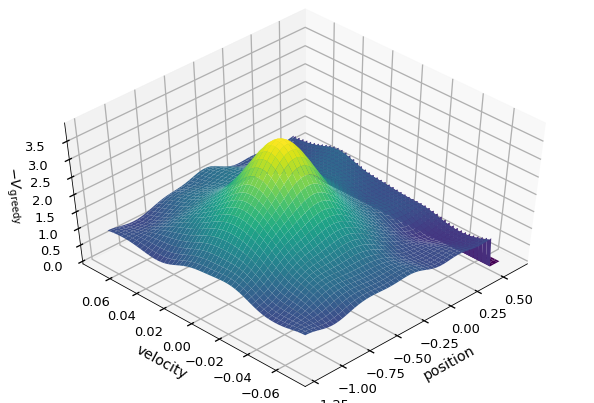

episode 1, length 200
episode 2, length 200
episode 3, length 200
episode 4, length 200
episode 5, length 200
episode 6, length 200
episode 7, length 200
episode 8, length 200
episode 9, length 200
episode 10, length 200
episode 11, length 200
episode 12, length 200
episode 13, length 200
episode 14, length 200
episode 15, length 200
episode 16, length 200
episode 17, length 200
episode 18, length 200
episode 19, length 200
episode 20, length 200
episode 21, length 200
episode 22, length 200
episode 23, length 200
episode 24, length 200
episode 25, length 200
episode 26, length 200
episode 27, length 200
episode 28, length 200
episode 29, length 200
episode 30, length 200
episode 31, length 200
episode 32, length 200
episode 33, length 200
episode 34, length 200
episode 35, length 200
episode 36, length 200
episode 37, length 161
episode 38, length 186
episode 39, length 200
episode 40, length 200
episode 41, length 200
episode 42, length 157
episode 43, length 199
episode 44, length 1

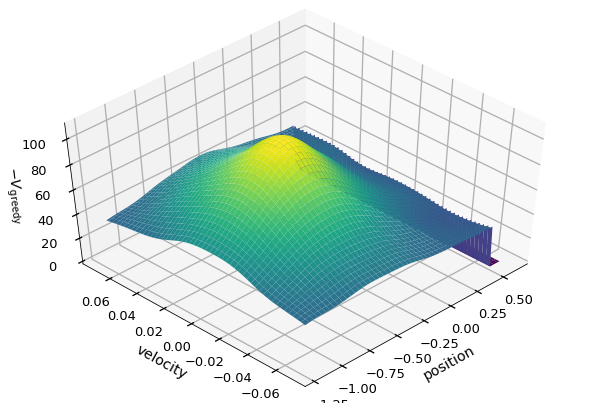

episode 51, length 200
episode 52, length 156
episode 53, length 200
episode 54, length 152
episode 55, length 127
episode 56, length 177
episode 57, length 171
episode 58, length 200
episode 59, length 195
episode 60, length 130
episode 61, length 124
episode 62, length 124
episode 63, length 200
episode 64, length 139
episode 65, length 118
episode 66, length 167
episode 67, length 117
episode 68, length 136
episode 69, length 177
episode 70, length 125
episode 71, length 160
episode 72, length 122
episode 73, length 107
episode 74, length 144
episode 75, length 153
episode 76, length 123
episode 77, length 170
episode 78, length 116
episode 79, length 151
episode 80, length 120
episode 81, length 183
episode 82, length 152
episode 83, length 132
episode 84, length 194
episode 85, length 123
episode 86, length 115
episode 87, length 163
episode 88, length 159
episode 89, length 176
episode 90, length 112
episode 91, length 156
episode 92, length 118
episode 93, length 178
episode 94,

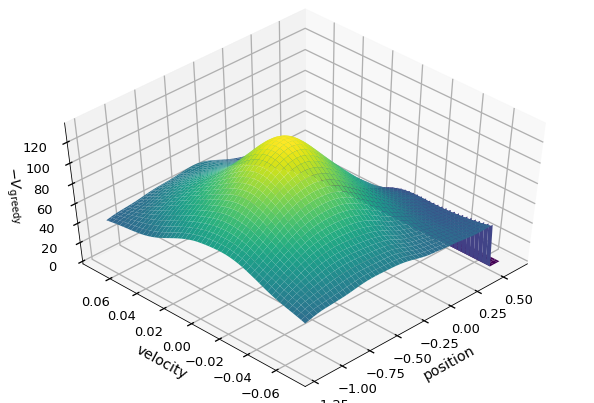

episode 101, length 115
episode 102, length 181
episode 103, length 160
episode 104, length 193
episode 105, length 110
episode 106, length 199
episode 107, length 200
episode 108, length 157
episode 109, length 185
episode 110, length 181
episode 111, length 200
episode 112, length 114
episode 113, length 115
episode 114, length 126
episode 115, length 173
episode 116, length 200
episode 117, length 200
episode 118, length 153
episode 119, length 162
episode 120, length 124
episode 121, length 177
episode 122, length 162
episode 123, length 127
episode 124, length 155
episode 125, length 163
episode 126, length 196
episode 127, length 187
episode 128, length 170
episode 129, length 200
episode 130, length 171
episode 131, length 194
episode 132, length 109
episode 133, length 109
episode 134, length 178
episode 135, length 176
episode 136, length 175
episode 137, length 141
episode 138, length 144
episode 139, length 119
episode 140, length 170
episode 141, length 119
episode 142, len

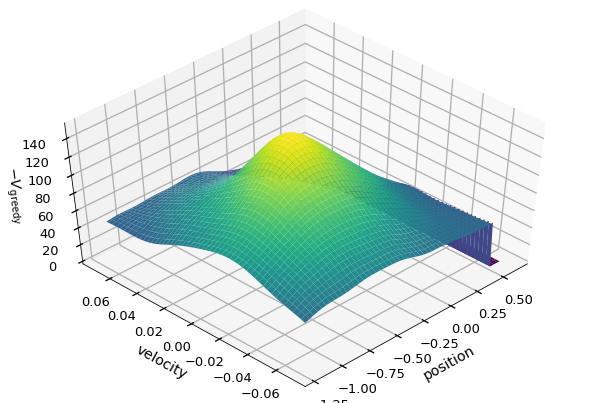

episode 151, length 116
episode 152, length 200
episode 153, length 141
episode 154, length 154
episode 155, length 140
episode 156, length 145
episode 157, length 161
episode 158, length 165
episode 159, length 117
episode 160, length 200
episode 161, length 118
episode 162, length 144
episode 163, length 142
episode 164, length 188
episode 165, length 147
episode 166, length 139
episode 167, length 179
episode 168, length 110
episode 169, length 154
episode 170, length 137
episode 171, length 183
episode 172, length 173
episode 173, length 170
episode 174, length 158
episode 175, length 165
episode 176, length 165
episode 177, length 143
episode 178, length 145
episode 179, length 140
episode 180, length 144
episode 181, length 143
episode 182, length 125
episode 183, length 144
episode 184, length 143
episode 185, length 145
episode 186, length 153
episode 187, length 144
episode 188, length 132
episode 189, length 142
episode 190, length 164
episode 191, length 141
episode 192, len

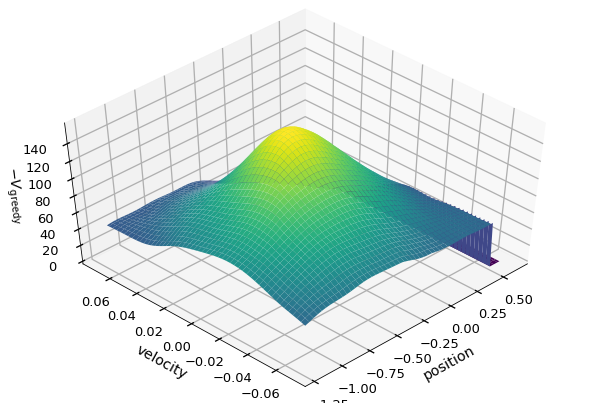

episode 201, length 169
episode 202, length 146
episode 203, length 139
episode 204, length 138
episode 205, length 176
episode 206, length 142
episode 207, length 136
episode 208, length 169
episode 209, length 146
episode 210, length 174
episode 211, length 140
episode 212, length 153
episode 213, length 146
episode 214, length 173
episode 215, length 142
episode 216, length 145
episode 217, length 145
episode 218, length 145
episode 219, length 200
episode 220, length 135
episode 221, length 152
episode 222, length 141
episode 223, length 140
episode 224, length 134
episode 225, length 140
episode 226, length 135
episode 227, length 147
episode 228, length 140
episode 229, length 144
episode 230, length 200
episode 231, length 146
episode 232, length 157
episode 233, length 200
episode 234, length 147
episode 235, length 200
episode 236, length 147
episode 237, length 151
episode 238, length 151
episode 239, length 143
episode 240, length 146
episode 241, length 148
episode 242, len

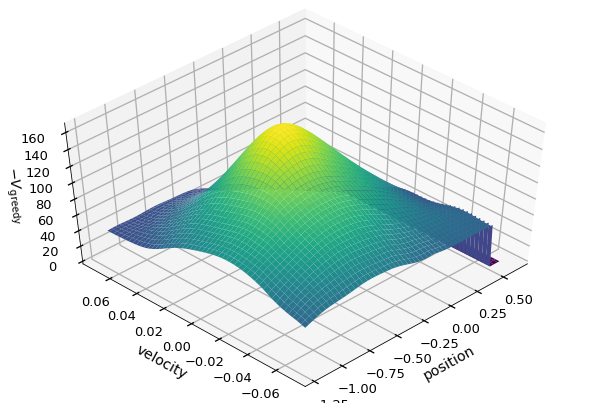

episode 251, length 144
episode 252, length 142
episode 253, length 145
episode 254, length 136
episode 255, length 136
episode 256, length 147
episode 257, length 157
episode 258, length 144
episode 259, length 200
episode 260, length 143
episode 261, length 155
episode 262, length 144
episode 263, length 146
episode 264, length 143
episode 265, length 198
episode 266, length 139
episode 267, length 140
episode 268, length 143
episode 269, length 145
episode 270, length 153
episode 271, length 142
episode 272, length 140
episode 273, length 148
episode 274, length 145
episode 275, length 145
episode 276, length 140
episode 277, length 146
episode 278, length 151
episode 279, length 165
episode 280, length 200
episode 281, length 142
episode 282, length 144
episode 283, length 141
episode 284, length 155
episode 285, length 147
episode 286, length 133
episode 287, length 148
episode 288, length 142
episode 289, length 190
episode 290, length 145
episode 291, length 144
episode 292, len

In [7]:
alpha = 0.01
gamma = 1
_lambda = 0.25 # we call it like that because lambda is a defined command in python
epsilon = 0.15
nb_episodes = 300

env = gym.make('MountainCar-v0')
state = env.reset()
feat_state = featurize(state, 0)
feat_dims = len(feat_state)

w = np.zeros(feat_dims)
w = np.expand_dims(w, axis=-1)


for j in tqdm(range(nb_episodes)):
    k = 0
    
    state = env.reset()
    feat_state, action = policy(state, w, env.action_space.n, epsilon)
    
    q_old = 0
    z = np.zeros_like(feat_state)
    
    while True:
        #env.render()
        k += 1
              
        # STEP
        next_state, reward, done, _ = env.step(action)
        feat_next_state, next_action = policy(next_state, w, env.action_space.n, epsilon)
        
        
        # LEARN
        q = np.transpose(w) @ feat_state
        q_prime = np.transpose(w) @ feat_next_state
        delta = reward + gamma * q_prime - q
        z = gamma * _lambda * z + (1 - alpha * gamma * _lambda * np.transpose(feat_state) @ z) * feat_state
        w = w + alpha * (delta + q - q_old) * z - alpha * (q - q_old) * feat_state
        q_old = q_prime
        
        
        feat_state = feat_next_state
        state = next_state
        action = next_action
        
        if done:
            print(f"episode {j}, length {k}")
            if j % 50 == 0:
                plot_surface_LSPI(w, feat_dims)
            break
        
    env.close()

### Greedy Execution

In [20]:
env.close()
env = gym.make('MountainCar-v0')
state = env.reset()

k = 0

while True:
    env.render()
    k += 1
    
    _, action = policy(state, w, env.action_space.n, 0)
    state, reward, done, _ = env.step(action)
    
    if done:
        break

print(k)
env.close()

135


## 3) Optional: Comparison

Compare the algorithms from exercise 11 to the ones from exercise 10. For which value of $\lambda$ and $\alpha$ do they learn the fastest? Have we achieved a major breakthrough?